# **Machine Learning Analysis on EEG Confusion Data**


## **Members:**


*  Anjali Ramesh
*  Ashna Sood 
*  Urmi Suresh
*  Sarvottam Jalsingh










Kaggle Notebook referenced: https://www.kaggle.com/gcdatkin/eeg-confusion-prediction-full-eda-ml

## **Introduction**

In [ ]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

#import patsy
#import statsmodels.api as sm
import scipy.stats as stats

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, mean_absolute_error, mean_squared_error, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

## **Data Cleanup**

In [ ]:
# load in EEG and Demographics datasets 
EEG_df = pd.read_csv("EEG_data.csv")
dem_df = pd.read_csv("demographic_info.csv")

In [ ]:
EEG_df

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12806,9.0,9.0,64.0,38.0,-39.0,127574.0,9951.0,709.0,21732.0,3872.0,39728.0,2598.0,960.0,1.0,0.0
12807,9.0,9.0,61.0,35.0,-275.0,323061.0,797464.0,153171.0,145805.0,39829.0,571280.0,36574.0,10010.0,1.0,0.0
12808,9.0,9.0,60.0,29.0,-426.0,680989.0,154296.0,40068.0,39122.0,10966.0,26975.0,20427.0,2024.0,1.0,0.0
12809,9.0,9.0,60.0,29.0,-84.0,366269.0,27346.0,11444.0,9932.0,1939.0,3283.0,12323.0,1764.0,1.0,0.0


In [ ]:
# drop unecessary columns and rename columns to eventually combine dfs
dem_df = dem_df.drop(columns={" ethnicity"})
dem_df = dem_df.rename(columns={"subject ID":"SubjectID", " age":"Age", " gender": "Gender", })
# binarize the Gender values to 1 - Female and 0 - Male
dem_df["Gender"] = dem_df["Gender"].apply(lambda x: 1  if x == 'F' else 0)
dem_df.head()

,SubjectID,Age,Gender
0,0,25,0
1,1,24,0
2,2,31,0
3,3,28,1
4,4,24,0


In [ ]:
# merge the EEG and demographic dataframes 
df = dem_df.merge(EEG_df, on="SubjectID")
# the y in our model
df = df.rename(columns={"user-definedlabeln": "Label"})
# pre-assigned variable of the confusion of the video by the researchers will alter the results of the classification
df = df.drop(columns={"predefinedlabel"})
df.head()

,SubjectID,Age,Gender,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Label
0,0,25,0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0
1,0,25,0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0
2,0,25,0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0
3,0,25,0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0
4,0,25,0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0


In [ ]:
# check for null values 
print("Missing Values?",df.isna().values.any())

Missing Values? False


## **EDA**

In [ ]:
# show the described data
df.describe()

,SubjectID,Age,Gender,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,Label
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000
mean,4.487394,25.409960,0.200999,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.512606
std,2.865373,2.205148,0.400763,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499861
min,0.000000,24.000000,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000
25%,2.000000,24.000000,0.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000
50%,4.000000,25.000000,0.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,1.000000
75%,7.000000,25.000000,0.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000
max,9.000000,31.000000,1.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000


In [ ]:
# see all column names to scope the most important features 
df.columns

Index(['SubjectID', 'Age', 'Gender', 'VideoID', 'Attention', 'Mediation',
       'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1',
       'Gamma2', 'Label'],
      dtype='object')

In [ ]:
# see correlations between variables, excluding Subject and Video ID
features = ['SubjectID', 'VideoID', 'Attention', 'Mediation','Raw', 'Delta', 'Theta', 'Alpha1', 
            'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
EEG_corrs = df[features[2:]].corr()
EEG_corrs = EEG_corrs.round(3)
EEG_corrs

,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2
Attention,1.000,0.549,-0.095,-0.220,-0.258,-0.199,-0.247,-0.255,-0.307,-0.300,-0.313
Mediation,0.549,1.000,-0.107,-0.112,-0.180,-0.043,-0.154,-0.241,-0.391,-0.345,-0.373
Raw,-0.095,-0.107,1.000,0.049,0.053,0.045,0.064,0.091,0.174,0.187,0.206
Delta,-0.220,-0.112,0.049,1.000,0.483,0.427,0.410,0.395,0.261,0.210,0.219
Theta,-0.258,-0.180,0.053,0.483,1.000,0.587,0.554,0.556,0.369,0.300,0.309
Alpha1,-0.199,-0.043,0.045,0.427,0.587,1.000,0.565,0.549,0.318,0.268,0.324
Alpha2,-0.247,-0.154,0.064,0.410,0.554,0.565,1.000,0.627,0.465,0.375,0.456
Beta1,-0.255,-0.241,0.091,0.395,0.556,0.549,0.627,1.000,0.480,0.422,0.527
Beta2,-0.307,-0.391,0.174,0.261,0.369,0.318,0.465,0.480,1.000,0.809,0.693
Gamma1,-0.300,-0.345,0.187,0.210,0.300,0.268,0.375,0.422,0.809,1.000,0.740


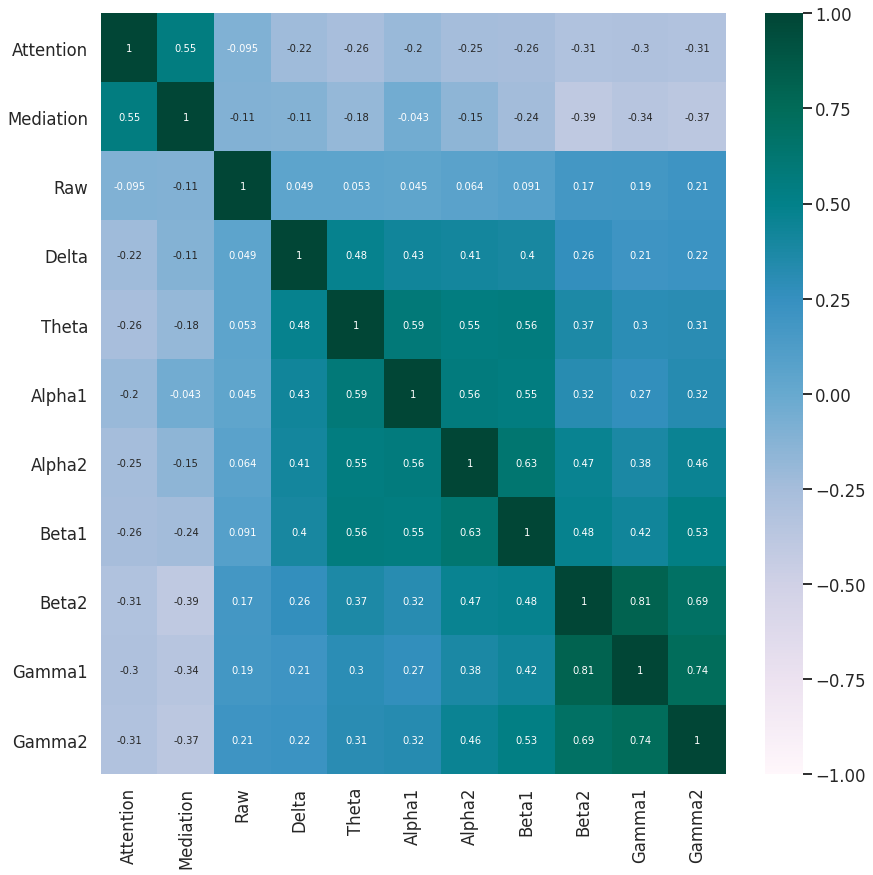

In [ ]:
# visualize correlation matrix in a heatmap to easily depict the highly correlated variables
plt.figure(figsize=(14, 14))
sns.heatmap(EEG_corrs, annot=True, vmin=-1.0, cmap='PuBuGn')
plt.show()

In [ ]:
# print out the exact values to make sure that the samples are evenly split between confused & not confused
print("Label count:\n", df["Label"].value_counts())
print("Subject ID count:\n", df["SubjectID"].value_counts())
print("Video ID count:\n", df["VideoID"].value_counts())

Label count:
 1.0    6567
0.0    6244
Name: Label, dtype: int64
Subject ID count:
 3    1314
1    1301
4    1295
2    1284
8    1282
7    1276
6    1275
5    1262
9    1261
0    1261
Name: SubjectID, dtype: int64
Video ID count:
 1.0    1414
0.0    1412
4.0    1356
9.0    1281
8.0    1280
2.0    1274
5.0    1230
3.0    1206
6.0    1181
7.0    1177
Name: VideoID, dtype: int64


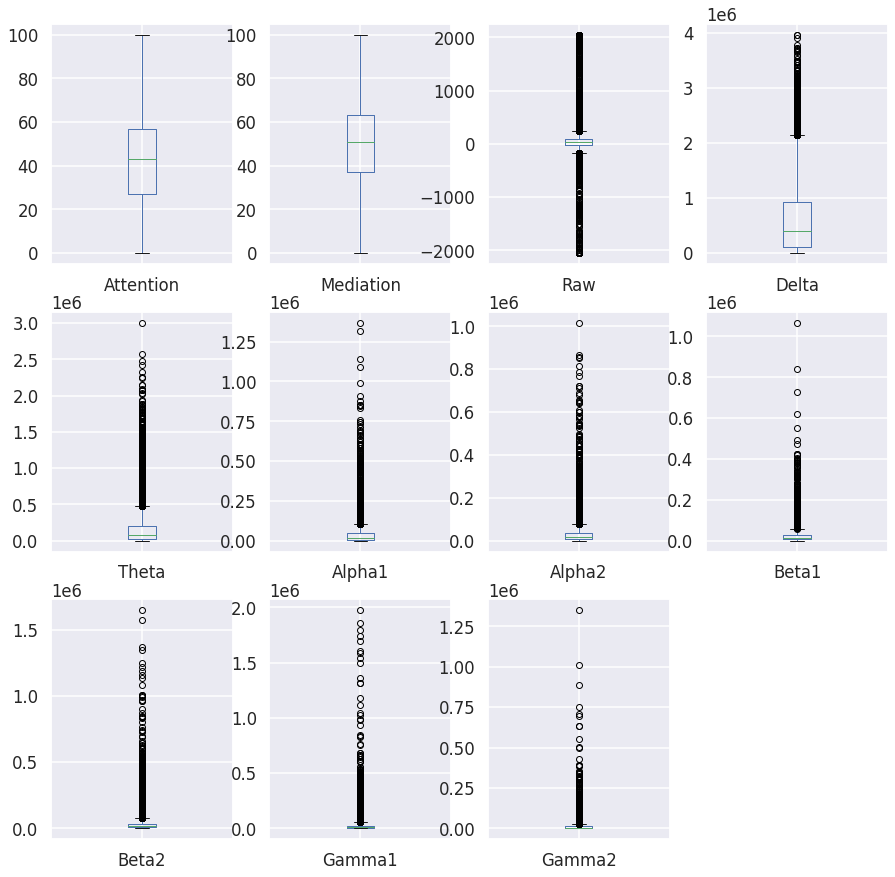

In [ ]:
# univariate analysis for continuous features to visualize the distributions of the variables  
df[features[2:]].plot(kind='box', figsize=(15, 15), subplots=True, layout=(3, 4))
plt.show()

## **Data Analysis**

### **Logistic Regression**

In [ ]:
# first define our X and y
X = df[features]
y = df['Label']

# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# standardize values -- ended up later not improving results 
#Xsc =  StandardScaler().fit_transform(X_train)

# create and train the logistic regression model 
lr_model = LogisticRegression(penalty="l1", solver="liblinear", C=0.1, random_state=120)
lr_model.fit(X_train, y_train)

# calculate training set accuracy 
lr_train_acc = lr_model.score(X_train, y_train)
print("Training Set accuracy:", lr_train_acc)

# make predictions
lr_pred = (lr_model.predict(X_test))
lr_true = y_test
# calculate testing set accuracy 
lr_test_acc = accuracy_score(lr_true, lr_pred)
print("Test Set accuracy:", lr_test_acc)

Training Set accuracy: 0.6052888368462139
Test Set accuracy: 0.5879828326180258


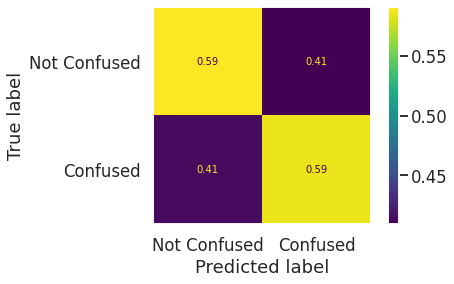

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(lr_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# caclulate metrics -- precision, recall, F1 score
print(classification_report(lr_true, lr_pred, target_names = ['Not Confused', 'Confused']))

              precision    recall  f1-score   support

Not Confused       0.59      0.59      0.59      1278
    Confused       0.59      0.59      0.59      1285

    accuracy                           0.59      2563
   macro avg       0.59      0.59      0.59      2563
weighted avg       0.59      0.59      0.59      2563



In [ ]:
# method to calculate metrics
def calculate_metrics(y_true, y_pred):
  # create a dictionary with all metrics: sensitivity (aka recall), specificity, precision, F1 score, and accuracy 
  tp, fn, fp, tn = confusion_matrix(y_true, y_pred).ravel()
  metrics_dict = {"Accuracy": np.round((tp + tn) / (tp + fn + fp + tn), 3),
                "Sensitivity": np.round(tp / (tp + fn), 3), 
                "Specificity": np.round(tn / (tn + fp), 3), 
                "Precision": np.round(tp / (tp + fp), 3), 
                "Recall": np.round(tp / (tp + fn), 3),
                "F1 Score": np.round(2 * ((tp / (tp + fp)) * (tp / (tp + fn))) / ((tp / (tp + fp)) + (tp / (tp + fn))), 3)}
  return metrics_dict

In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
lr_metrics = calculate_metrics(lr_true, lr_pred)
print("Logistic Regression Metrics:\n", lr_metrics)

Logistic Regression Metrics:
 {'Accuracy': 0.588, 'Sensitivity': 0.591, 'Specificity': 0.585, 'Precision': 0.586, 'Recall': 0.591, 'F1 Score': 0.588}


In [ ]:
# results of logistic regression model actual vs predicteds
result1 = pd.DataFrame({'Actual': lr_true, 'Predicted': lr_pred})
result1.head()

,Actual,Predicted
133,0.0,1.0
3955,0.0,1.0
6469,0.0,0.0
11220,0.0,0.0
343,1.0,0.0


In [ ]:
# calculate regressor metrics MSE and RMSE for logistic regression model
lr_mse = mean_squared_error(lr_true, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(lr_true, lr_pred))

print("LR MSE:", lr_mse)
print("LR RMSE:", lr_rmse)

LR MSE: 0.41201716738197425
LR RMSE: 0.6418856341919285


In [ ]:
# K folds cross validation -- observe generalization error 

lr_model = LogisticRegression(penalty="l1", solver="liblinear", C=0.1, random_state=120)
k_fold = KFold(n_splits=15)
#Xsc =  StandardScaler().fit_transform(X_train)

# collect the predicted y values and true y values of each test set
predicteds=[]
trueys=[]
accuracy=[]
for train_ind, test_ind in k_fold.split(X):
  X_train, X_test = X.loc[train_ind], X.loc[test_ind]
  y_train, y_test = y.loc[train_ind], y.loc[test_ind]
  lr_model.fit(X_train, y_train)
  predicteds.append(lr_model.predict(X_test))
  trueys.append(y_test)
  accuracy.append(lr_model.score(X_test, y_test))

# flatten array to all the folds together
predicteds = np.concatenate(predicteds)
trueys = np.concatenate(trueys)
# calculate average test accuracy from all k folds 
print("overall accuracy:", accuracy_score(trueys,predicteds))
print("15-folds accuracies:\n", accuracy)

# calculate the average metrics from all k folds 
lr_metrics = calculate_metrics(trueys, predicteds)
print("Logistic Regression Metrics:\n", lr_metrics)

overall accuracy: 0.5240028100850831
15-folds accuracies:
 [0.6093567251461989, 0.6381733021077284, 0.35714285714285715, 0.49414519906323184, 0.39344262295081966, 0.5058548009367682, 0.5819672131147541, 0.5023419203747073, 0.6838407494145199, 0.531615925058548, 0.4637002341920375, 0.6206088992974239, 0.4426229508196721, 0.6124121779859485, 0.42271662763466045]
Logistic Regression Metrics:
 {'Accuracy': 0.524, 'Sensitivity': 0.48, 'Specificity': 0.565, 'Precision': 0.512, 'Recall': 0.48, 'F1 Score': 0.496}


###**SVM**

In [ ]:
# first define our X and y
X = df[features]
y = df['Label']

# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# train the SVM model using 3 different kernels to determine the optimal kernel 
train_acc = []
test_acc = []
kernels = ["rbf", "linear", "poly"]
for ind, kernel in enumerate(kernels):
  # create and train the SVM model 
  svm_model = make_pipeline(StandardScaler(), SVC(C=1, gamma='auto', kernel=kernel))
  svm_model.fit(X_train, y_train)
  # store training accuracy for each model 
  train_acc.append(svm_model.score(X_train, y_train))
  # calculate predictions and store testing accuracy for each model 
  svm_preds = svm_model.predict(X_test)
  test_acc.append(accuracy_score(y_test, svm_preds)) 
  print(kernel, "kernel: Train Set acc:", train_acc[ind], " Test Set acc:", test_acc[ind])

rbf kernel: Train Set acc: 0.7087236533957846  Test Set acc: 0.6808427623878268
linear kernel: Train Set acc: 0.5990437158469946  Test Set acc: 0.5856418259851737
poly kernel: Train Set acc: 0.6693013270882123  Test Set acc: 0.6453374951229028


Based off of the three models created with different kernels, the rbf kernel seems to perform the best, so that is the chosen optimal kernel.

In [ ]:
# train SVM model using 5 different C values to determine the optimal parameter 
train_acc = []
test_acc = []
C = [1, 10, 100, 1000, 10000, 100000]
for ind, Cval in enumerate(C):
  # create SVM model and train the model 
  svm_model = make_pipeline(StandardScaler(), SVC(C=Cval, gamma='auto', kernel="rbf"))
  svm_model.fit(X_train, y_train)
  # store training accuracy for each model 
  train_acc.append(svm_model.score(X_train, y_train))
  # calculate predictions and store testing accuracy for each model 
  svm_preds = svm_model.predict(X_test)
  test_acc.append(accuracy_score(y_test, svm_preds)) 
  print(Cval, "C: Train Set acc:", train_acc[ind], " Test Set acc:", test_acc[ind])

1 C: Train Set acc: 0.7087236533957846  Test Set acc: 0.6808427623878268
10 C: Train Set acc: 0.7665886026541764  Test Set acc: 0.7171283651970347
100 C: Train Set acc: 0.8282591725214676  Test Set acc: 0.7331252438548576
1000 C: Train Set acc: 0.9016393442622951  Test Set acc: 0.760827155676941
10000 C: Train Set acc: 0.9440866510538641  Test Set acc: 0.7737026921576278
100000 C: Train Set acc: 0.9735558157689306  Test Set acc: 0.7577058134998049


Since the accuracy after C = 1000 only slightly improves, in order to save computation time, the optimal C value chosen is 1000.

In [ ]:
# using optimal kernal - rbf and optimal C value - 1000, train the SVM model 
svm_model = make_pipeline(StandardScaler(), SVC(C=1000, gamma='auto', kernel="rbf"))
svm_model.fit(X_train, y_train)
# calculate the training accuracy
svm_train_acc = svm_model.score(X_train, y_train)
print("Training Set accuracy", svm_train_acc)

# make predictions and calculate the testing accuracy
svm_pred = svm_model.predict(X_test)
svm_true = y_test
svm_test_acc = accuracy_score(y_test, svm_pred)
print("Test Set accuracy", svm_test_acc)

Training Set accuracy 0.9016393442622951
Test Set accuracy 0.760827155676941


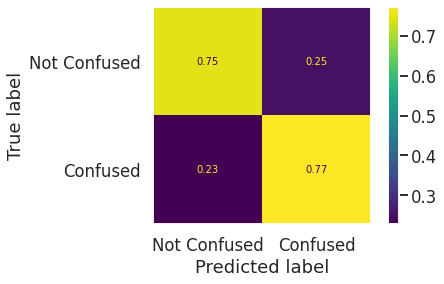

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(svm_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate metrics -- precision, recall, F1 score
print(classification_report(svm_true, svm_pred, target_names = ['Not Confused', 'Confused']))

              precision    recall  f1-score   support

Not Confused       0.77      0.75      0.76      1278
    Confused       0.76      0.77      0.76      1285

    accuracy                           0.76      2563
   macro avg       0.76      0.76      0.76      2563
weighted avg       0.76      0.76      0.76      2563



In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
svm_metrics = calculate_metrics(svm_true, svm_pred)
print("SVM Metrics:\n", svm_metrics)

SVM Metrics:
 {'Accuracy': 0.761, 'Sensitivity': 0.749, 'Specificity': 0.773, 'Precision': 0.766, 'Recall': 0.749, 'F1 Score': 0.757}


In [ ]:
# results of SVM model actual vs predicteds
result2 = pd.DataFrame({'Actual': svm_true, 'Predicted': svm_pred})
result2.head()

,Actual,Predicted
133,0.0,0.0
3955,0.0,0.0
6469,0.0,0.0
11220,0.0,0.0
343,1.0,0.0


In [ ]:
# calculate regressor metrics MSE and RMSE for SVM model
svm_mse = mean_squared_error(svm_true, svm_pred)
svm_rmse = np.sqrt(mean_squared_error(svm_true, svm_pred))

print("SVM MSE:", svm_mse)
print("SVM RMSE:", svm_rmse)

SVM MSE: 0.2391728443230589
SVM RMSE: 0.4890530076822541


In [ ]:
# K folds cross validation -- observe generalization error 
k_fold = KFold(n_splits=5)

# collect the predicted y values and true y values of each hold out set
predicteds=[]
trueys=[]
accuracy=[]
for train_ind, test_ind in k_fold.split(X):
  X_train, X_test = X.loc[train_ind], X.loc[test_ind]
  y_train, y_test = y.loc[train_ind], y.loc[test_ind]
  svm_model.fit(X_train, y_train)
  predicteds.append(svm_model.predict(X_test))
  trueys.append(y_test)
  accuracy.append(svm_model.score(X_test, y_test))

# flatten array to all the folds together
predicteds = np.concatenate(predicteds)
trueys = np.concatenate(trueys)
# calculate average test accuracy from all k folds 
print("overall accuracy:", accuracy_score(trueys,predicteds))
print("5-folds accuracies:\n", accuracy)

# calculate the average metrics from all k folds 
svm_metrics = calculate_metrics(trueys, predicteds)
print("SVM Metrics:\n", svm_metrics)

overall accuracy: 0.5061275466396066
5-folds accuracies:
 [0.4701521654311354, 0.4672131147540984, 0.5663544106167057, 0.5386416861826698, 0.4882903981264637]
SVM Metrics:
 {'Accuracy': 0.506, 'Sensitivity': 0.474, 'Specificity': 0.537, 'Precision': 0.493, 'Recall': 0.474, 'F1 Score': 0.483}


### **K-Nearest Neighbors**

In [ ]:
# first define our X and y
X = df[features]
y = df['Label']

# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# train model with 7 different k neighbors to determine the optimal k value 
neighbors = [3, 5, 7, 9, 11, 13, 15]
knn_predicteds=[]

for k in neighbors:
  # create and train the KNN model 
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(X_train,y_train)
  # calculate the training accuracy
  knn_train_acc = knn_model.score(X_train, y_train)
  print("Training Set accuracy for k =", k, " ", knn_train_acc)

  # make predictions and calculate the testing accuracy
  knn_pred = knn_model.predict(X_test)
  knn_true = y_test
  knn_test_acc = accuracy_score(knn_true, knn_pred)
  print("Test Set accuracy for k =", k, " ", knn_test_acc)
  # add testing accuracy to eventually plot the accuracies for each k value 
  knn_predicteds.append(knn_test_acc)

Training Set accuracy for k = 3   0.7729313036690086
Test Set accuracy for k = 3   0.5528677331252438
Training Set accuracy for k = 5   0.7157494145199064
Test Set accuracy for k = 5   0.5567694108466641
Training Set accuracy for k = 7   0.688231850117096
Test Set accuracy for k = 7   0.5516972298088177
Training Set accuracy for k = 9   0.669496487119438
Test Set accuracy for k = 9   0.5665236051502146
Training Set accuracy for k = 11   0.6597384855581577
Test Set accuracy for k = 11   0.5704252828716349
Training Set accuracy for k = 13   0.650663544106167
Test Set accuracy for k = 13   0.5622317596566524
Training Set accuracy for k = 15   0.6460772833723654
Test Set accuracy for k = 15   0.5618415918845103


Based off of the models created, it seems that the accuracy after k = 3 neighbors seems to be in the same range, so there is no added benefit to using a higher number of neighbors. To further visualize the accuracies, we plotted the values below. 

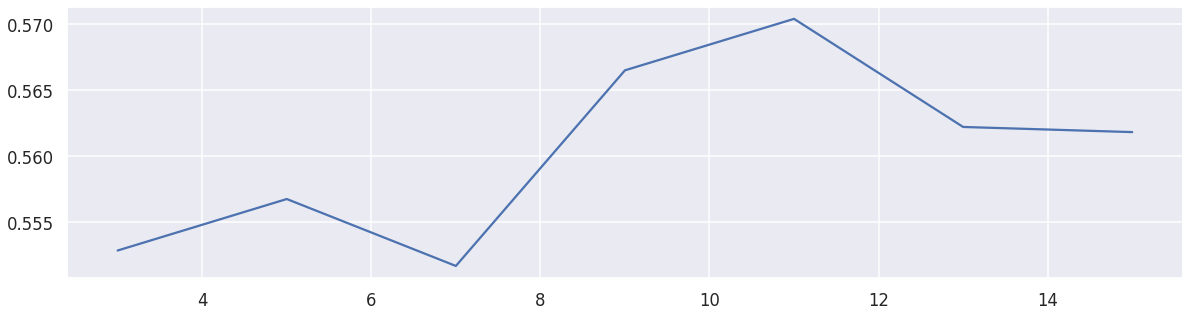

In [ ]:
# plot the test accuracies for each k value model to evaluate which model performs best 
plt.figure(figsize=(20,5))
plt.plot(neighbors, knn_predicteds)
plt.show()

In [ ]:
# since the accuracy after 11 neighbors does not improve drastically, stick with k = 11

# create and train the KNN model 
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)
# calculate the training accuracy
knn_train_acc = knn_model.score(X_train, y_train)
print("Training Set accuracy for k = 11:", knn_train_acc)

# make predictions and calculate the testing accuracy
knn_pred = knn_model.predict(X_test)
knn_true = y_test
knn_test_acc = accuracy_score(knn_true, knn_pred)
print("Test Set accuracy for k = 11:", knn_test_acc)

Training Set accuracy for k = 11: 0.6597384855581577
Test Set accuracy for k = 11: 0.5704252828716349


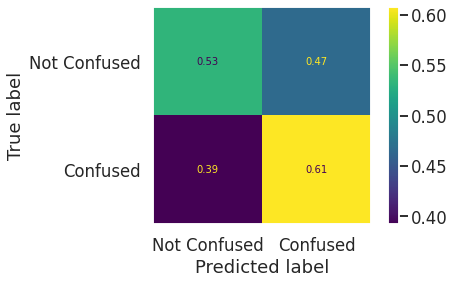

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(knn_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate metrics -- precision, recall, F1 score
print(classification_report(knn_true, knn_pred, target_names = ['Not Confused', 'Confused']))

              precision    recall  f1-score   support

Not Confused       0.57      0.53      0.55      1278
    Confused       0.57      0.61      0.59      1285

    accuracy                           0.57      2563
   macro avg       0.57      0.57      0.57      2563
weighted avg       0.57      0.57      0.57      2563



In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
knn_metrics = calculate_metrics(knn_true, knn_pred)
print("KNN Metrics:\n", knn_metrics)

KNN Metrics:
 {'Accuracy': 0.57, 'Sensitivity': 0.533, 'Specificity': 0.608, 'Precision': 0.575, 'Recall': 0.533, 'F1 Score': 0.553}


In [ ]:
# results of KNN model actual vs predicteds
result3 = pd.DataFrame({'Actual': knn_true, 'Predicted': knn_pred})
result3.head()

,Actual,Predicted
133,0.0,1.0
3955,0.0,1.0
6469,0.0,0.0
11220,0.0,0.0
343,1.0,0.0


In [ ]:
# calculate regressor metrics MSE and RMSE for KNN model
knn_mse = mean_squared_error(knn_true, knn_pred)
knn_rmse = np.sqrt(mean_squared_error(knn_true, knn_pred))

print("KNN MSE:", knn_mse)
print("KNN RMSE:", knn_rmse)

KNN MSE: 0.4295747171283652
KNN RMSE: 0.6554194970615119


In [ ]:
# K folds cross validation -- observe generalization error 
k_fold = KFold(n_splits=15)

# collect the predicted y values and true y values of each hold out set
predicteds=[]
trueys=[]
accuracy=[]
for train_ind, test_ind in k_fold.split(X):
  X_train, X_test = X.loc[train_ind], X.loc[test_ind]
  y_train, y_test = y.loc[train_ind], y.loc[test_ind]
  knn_model.fit(X_train, y_train)
  predicteds.append(knn_model.predict(X_test))
  trueys.append(y_test)
  accuracy.append(knn_model.score(X_test, y_test))

# flatten array to all the folds together
predicteds = np.concatenate(predicteds)
trueys = np.concatenate(trueys)
# calculate average test accuracy from all k folds 
print("overall accuracy:", accuracy_score(trueys,predicteds))
print("15-folds accuracies:\n", accuracy)

# calculate the average metrics from all k folds 
knn_metrics = calculate_metrics(trueys, predicteds)
print("KNN Metrics:\n", knn_metrics)

overall accuracy: 0.5269690110061666
15-folds accuracies:
 [0.5614035087719298, 0.5339578454332553, 0.4859484777517564, 0.49765807962529274, 0.49882903981264637, 0.5655737704918032, 0.5011709601873536, 0.5245901639344263, 0.5761124121779859, 0.48360655737704916, 0.49414519906323184, 0.5538641686182669, 0.5, 0.5281030444964872, 0.5995316159250585]
KNN Metrics:
 {'Accuracy': 0.527, 'Sensitivity': 0.493, 'Specificity': 0.559, 'Precision': 0.515, 'Recall': 0.493, 'F1 Score': 0.504}


###**Random Forests**

In [ ]:
# first define our X and y
X = df[features]
y = df['Label']

# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# create and train the Random Forests model 
# also trained with n_estimators 200, 500, and 2000, but 1000 was the optimal value 
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=13)
rf_model.fit(X_train,y_train)

# calculate the training accuracy
rf_train_acc = rf_model.score(X_train, y_train)
print("Training Set accuracy:", lr_train_acc)

# make predictions and calculate the testing accuracy
rf_pred = (rf_model.predict(X_test))
rf_true = y_test
rf_test_acc = accuracy_score(rf_true, rf_pred)
print("Test Set accuracy:", rf_test_acc)

Training Set accuracy: 0.6052888368462139
Test Set accuracy: 0.6215372610222396


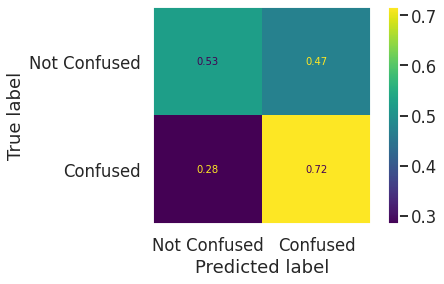

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(rf_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate metrics -- precision, recall, F1 score
print(classification_report(rf_true, rf_pred, target_names = ['Not Confused', 'Confused']))

              precision    recall  f1-score   support

Not Confused       0.65      0.53      0.58      1278
    Confused       0.60      0.72      0.66      1285

    accuracy                           0.62      2563
   macro avg       0.63      0.62      0.62      2563
weighted avg       0.63      0.62      0.62      2563



In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
rf_metrics = calculate_metrics(rf_true, rf_pred,)
print("Random Forest Metrics:\n", rf_metrics)

Random Forest Metrics:
 {'Accuracy': 0.622, 'Sensitivity': 0.526, 'Specificity': 0.717, 'Precision': 0.649, 'Recall': 0.526, 'F1 Score': 0.581}


In [ ]:
# results of Random Forests model actual vs predicteds
result4 = pd.DataFrame({'Actual': rf_true, 'Predicted': rf_pred})
result4.head()

,Actual,Predicted
133,0.0,1.0
3955,0.0,1.0
6469,0.0,0.0
11220,0.0,0.0
343,1.0,1.0


In [ ]:
# calculate regressor metrics MSE and RMSE for Random Forests model
rf_mse = mean_squared_error(rf_true, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(rf_true, rf_pred))

print("RF MSE:", rf_mse)
print("RF RMSE:", rf_rmse)

RF MSE: 0.37846273897776045
RF RMSE: 0.6151932533584552


In [ ]:
# K folds cross validation -- observe generalization error 
k_fold = KFold(n_splits=5)

# collect the predicted y values and true y values of each hold out set
predicteds=[]
trueys=[]
accuracy=[]
for train_ind, test_ind in k_fold.split(X):
  X_train, X_test = X.loc[train_ind], X.loc[test_ind]
  y_train, y_test = y.loc[train_ind], y.loc[test_ind]
  rf_model.fit(X_train, y_train)
  predicteds.append(rf_model.predict(X_test))
  trueys.append(y_test)
  accuracy.append(rf_model.score(X_test, y_test))

# flatten array to all the folds together
predicteds = np.concatenate(predicteds)
trueys = np.concatenate(trueys)
# calculate average test accuracy from all k folds 
print("overall accuracy:", accuracy_score(trueys,predicteds))
print("5-folds accuracies:\n", accuracy)

# calculate the average metrics from all k folds 
rf_metrics = calculate_metrics(trueys, predicteds)
print("Random Forest Metrics:\n", rf_metrics)

overall accuracy: 0.5297790960892983
5-folds accuracies:
 [0.5200936402653141, 0.4957064793130367, 0.5850897736143638, 0.5612802498048399, 0.48672911787665885]
Random Forest Metrics:
 {'Accuracy': 0.53, 'Sensitivity': 0.471, 'Specificity': 0.586, 'Precision': 0.519, 'Recall': 0.471, 'F1 Score': 0.494}


###**PCA**

In [ ]:
# first define our X and y
X = df[features]
y = df['Label']

# split the data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# create and train the PCA model 
pca = PCA(n_components=2)
pca_model = pca.fit_transform(X_train)

Text(0, 0.5, 'Second Principle Component')

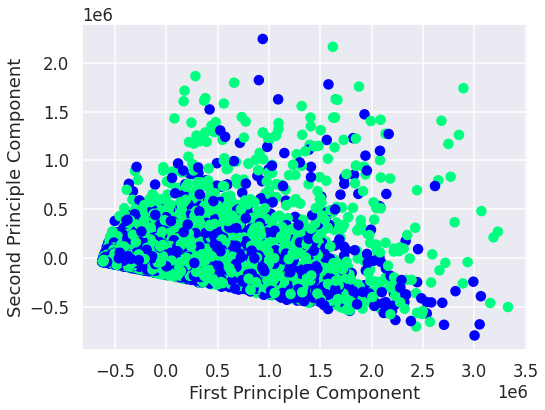

In [ ]:
# visualize the data with reduced dimensions 
plt.figure(figsize=(8,6))
plt.scatter(pca_model[:,0],pca_model[:,1], c=y_train, cmap='winter')
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')

##**Model Comparison**

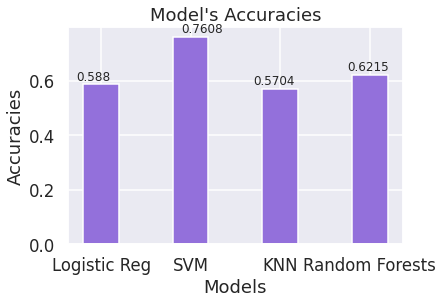

In [ ]:
# plot and visually compare the accuracies for each model
labels = ["Logistic Reg", "SVM", "KNN", "Random Forests"]
accuracies = np.round([lr_test_acc, svm_test_acc, knn_test_acc, rf_test_acc], 4)
plt.bar(labels, accuracies, color="mediumpurple", width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracies")
plt.title("Model's Accuracies")

# add the actual values on top of the bars 
for i, v in enumerate(accuracies):
  plt.text(accuracies[i] + (i - 0.87), v + 0.015, str(v), size=12)
plt.show()

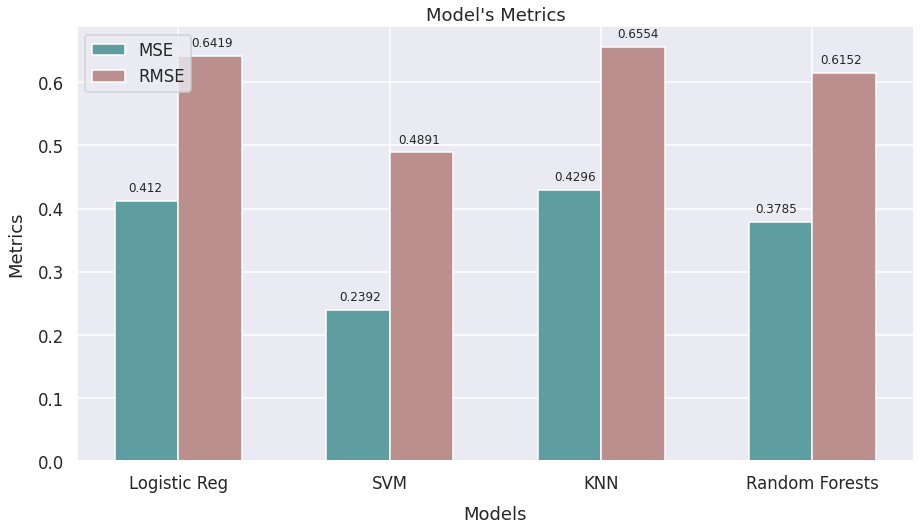

In [ ]:
# plot and visually compare the MSE and RMSE for each model
labels = ["Logistic Reg", "SVM", "KNN", "Random Forests"]
MSE = np.round([lr_mse, svm_mse, knn_mse, rf_mse], 4)
RMSE = np.round([lr_rmse, svm_rmse, knn_rmse, rf_rmse], 4)
ind = np.arange(4)
width = 0.3

plt.figure(figsize=(15, 8))
plt.bar(ind, MSE, width, label = "MSE", color="cadetblue")
plt.bar(ind + width, RMSE, width, label = "RMSE", color="rosybrown")

plt.xlabel("Models", labelpad=13)
plt.ylabel("Metrics", labelpad=13)
plt.xticks(ind + width/2, (labels))
plt.xticks(ha= "center")
plt.title("Model's Metrics")
plt.legend(loc="upper left")

# add the actual values on top of the bars 
for i, v in enumerate(MSE):
  # evenly space out SVM
  if i == 1:
    plt.text(MSE[i] + (i - 0.33), v + 0.015, str(v), size=12)
  # evenly space out the other 3 models
  else:
    plt.text(MSE[i] + (i - 0.5), v + 0.015, str(v), size=12)
for i, v in enumerate(RMSE):
  # evenly space out SVM
  if i == 1:
    plt.text(RMSE[i] + (i - 0.3), v + 0.015, str(v), size=12)
  # evenly space out the other 3 models
  else:
      plt.text(RMSE[i] + (i - 0.43), v + 0.015, str(v), size=12)
plt.show()

##**New Train/Test split training**

In this next section, after discussion in class and further clarification with the professor, we came to an understanding that a more appropriate way to split the training and test data is not to do random splits but instead to do an 80/20 train test split of each partiicpant's data. To briefly exlpore this, we focus on one subject and split the samples only from this subject in an 80/20 training test split. We then perform Logistic Regression, KNN, SVM, and Random Forest again using this newly split data just to get a broad idea of how this newly split data would have performed with these algorithms.

In [ ]:
print("Subject ID count:\n", df["SubjectID"].value_counts())

Subject ID count:
 3    1314
1    1301
4    1295
2    1284
8    1282
7    1276
6    1275
5    1262
9    1261
0    1261
Name: SubjectID, dtype: int64


In [ ]:
# train model on only one subject's data 
df_subject1 = df.loc[df['SubjectID'].isin(range(0,1))]
df_subject1.shape

(1261, 16)

In [ ]:
# 80/20 train test split -- 1008 train, 253 test 
df_train = df_subject1.iloc[:1008, :]
print("Train data shape:", df_train.shape)

df_test = df_subject1.iloc[1008:, :]
print("Test data shape:", df_test.shape)

Train data shape: (1008, 16)
Test data shape: (253, 16)


In [ ]:
# split the data into training and testing sets 
X_train = df_train[features]
y_train = df_train["Label"]

X_test = df_test[features]
y_test = df_test["Label"]

Logistic Regression Model

In [ ]:
# create and train the logistic regression model 
lr_model = LogisticRegression(penalty="l1", solver="liblinear", C=0.1, random_state=120)
lr_model.fit(X_train, y_train)

# calculate training set accuracy 
lr_train_acc = lr_model.score(X_train, y_train)
print("Training Set accuracy:", lr_train_acc)

# make predictions
lr_pred = (lr_model.predict(X_test))
lr_true = y_test
# calculate testing set accuracy 
lr_test_acc = accuracy_score(lr_true, lr_pred)
print("Test Set accuracy:", lr_test_acc)

Training Set accuracy: 0.6438492063492064
Test Set accuracy: 0.49407114624505927


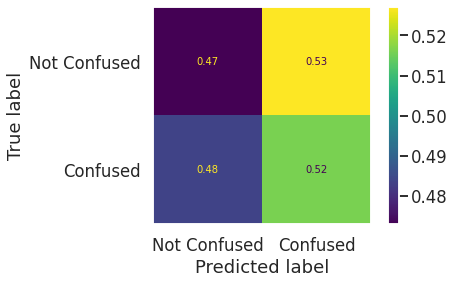

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(lr_model,X_test,y_test, normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
lr_metrics = calculate_metrics(lr_true, lr_pred)
print("Logistic Regression Metrics:\n", lr_metrics)

Logistic Regression Metrics:
 {'Accuracy': 0.494, 'Sensitivity': 0.473, 'Specificity': 0.516, 'Precision': 0.504, 'Recall': 0.473, 'F1 Score': 0.488}


In [ ]:
# calculate regressor metrics MSE and RMSE for logistic regression model
lr_mse = mean_squared_error(lr_true, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(lr_true, lr_pred))

print("LR MSE:", lr_mse)
print("LR RMSE:", lr_rmse)

LR MSE: 0.5059288537549407
LR RMSE: 0.7112867591590193


SVM Model 

In [ ]:
# using optimal kernal - rbf and optimal C value - 1000, train the SVM model 
svm_model = make_pipeline(StandardScaler(), SVC(C=1000, gamma='auto', kernel="linear"))
svm_model.fit(X_train, y_train)
# calculate the training accuracy
svm_train_acc = svm_model.score(X_train, y_train)
print("Training Set accuracy", svm_train_acc)

# make predictions and calculate the testing accuracy
svm_pred = svm_model.predict(X_test)
svm_true = y_test
svm_test_acc = accuracy_score(y_test, svm_pred)
print("Test Set accuracy", svm_test_acc)

Training Set accuracy 0.6656746031746031
Test Set accuracy 0.4782608695652174


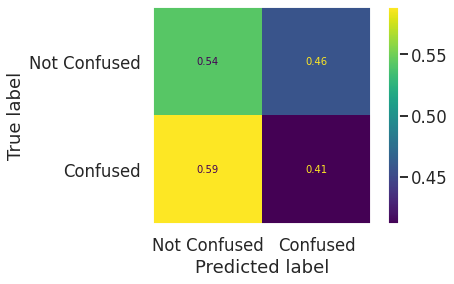

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(svm_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
svm_metrics = calculate_metrics(svm_true, svm_pred)
print("SVM Metrics:\n", svm_metrics)

SVM Metrics:
 {'Accuracy': 0.478, 'Sensitivity': 0.543, 'Specificity': 0.411, 'Precision': 0.49, 'Recall': 0.543, 'F1 Score': 0.515}


In [ ]:
# calculate regressor metrics MSE and RMSE for SVM model
svm_mse = mean_squared_error(svm_true, svm_pred)
svm_rmse = np.sqrt(mean_squared_error(svm_true, svm_pred))

print("SVM MSE:", svm_mse)
print("SVM RMSE:", svm_rmse)

SVM MSE: 0.5217391304347826
SVM RMSE: 0.7223151185146152


KNN Model

In [ ]:
# train model with 7 different k neighbors to determine the optimal k value 
neighbors = [3, 5, 7, 9, 11, 13, 15]
knn_predicteds=[]

for k in neighbors:
  # create and train the KNN model 
  knn_model = KNeighborsClassifier(n_neighbors=k)
  knn_model.fit(X_train,y_train)
  # calculate the training accuracy
  knn_train_acc = knn_model.score(X_train, y_train)
  print("Training Set accuracy for k =", k, " ", knn_train_acc)

  # make predictions and calculate the testing accuracy
  knn_pred = knn_model.predict(X_test)
  knn_true = y_test
  knn_test_acc = accuracy_score(knn_true, knn_pred)
  print("Test Set accuracy for k =", k, " ", knn_test_acc)
  # add testing accuracy to eventually plot the accuracies for each k value 
  knn_predicteds.append(knn_test_acc)

Training Set accuracy for k = 3   0.7817460317460317
Test Set accuracy for k = 3   0.5691699604743083
Training Set accuracy for k = 5   0.7132936507936508
Test Set accuracy for k = 5   0.5652173913043478
Training Set accuracy for k = 7   0.6944444444444444
Test Set accuracy for k = 7   0.5889328063241107
Training Set accuracy for k = 9   0.6716269841269841
Test Set accuracy for k = 9   0.6086956521739131
Training Set accuracy for k = 11   0.6626984126984127
Test Set accuracy for k = 11   0.6205533596837944
Training Set accuracy for k = 13   0.6636904761904762
Test Set accuracy for k = 13   0.5889328063241107
Training Set accuracy for k = 15   0.6577380952380952
Test Set accuracy for k = 15   0.6007905138339921


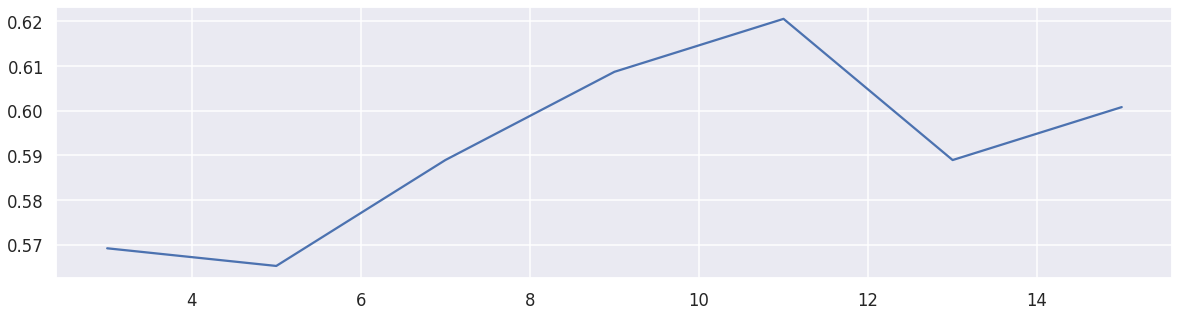

In [ ]:
# plot the test accuracies for each k value model to evaluate which model performs best 
plt.figure(figsize=(20,5))
plt.plot(neighbors, knn_predicteds)
plt.show()

In [ ]:
# since the accuracy after 11 neighbors does not improve drastically, stick with k = 11
# create and train the KNN model 
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(X_train, y_train)
# calculate the training accuracy
knn_train_acc = knn_model.score(X_train, y_train)
print("Training Set accuracy for k = 11:", knn_train_acc)

# make predictions and calculate the testing accuracy
knn_pred = knn_model.predict(X_test)
knn_true = y_test
knn_test_acc = accuracy_score(knn_true, knn_pred)
print("Test Set accuracy for k = 11:", knn_test_acc)

Training Set accuracy for k = 11: 0.6626984126984127
Test Set accuracy for k = 11: 0.6205533596837944


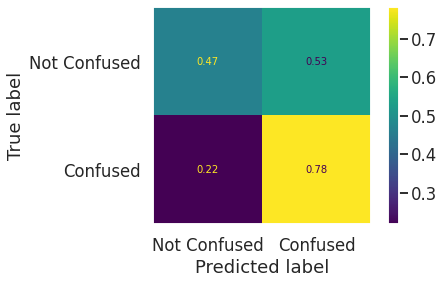

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(knn_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
knn_metrics = calculate_metrics(knn_true, knn_pred)
print("KNN Metrics:\n", knn_metrics)

KNN Metrics:
 {'Accuracy': 0.621, 'Sensitivity': 0.465, 'Specificity': 0.782, 'Precision': 0.69, 'Recall': 0.465, 'F1 Score': 0.556}


In [ ]:
# calculate regressor metrics MSE and RMSE for KNN model
knn_mse = mean_squared_error(knn_true, knn_pred)
knn_rmse = np.sqrt(mean_squared_error(knn_true, knn_pred))

print("KNN MSE:", knn_mse)
print("KNN RMSE:", knn_rmse)

KNN MSE: 0.3794466403162055
KNN RMSE: 0.6159924028072145


Random Forests Model

In [ ]:
# create and train the Random Forests model 
# also trained with n_estimators 200, 500, and 2000, but 1000 was the optimal value 
rf_model = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=13)
rf_model.fit(X_train,y_train)

# calculate the training accuracy
rf_train_acc = rf_model.score(X_train, y_train)
print("Training Set accuracy:", lr_train_acc)

# make predictions and calculate the testing accuracy
rf_pred = (rf_model.predict(X_test))
rf_true = y_test
rf_test_acc = accuracy_score(rf_true, rf_pred)
print("Test Set accuracy:", rf_test_acc)

Training Set accuracy: 0.6438492063492064
Test Set accuracy: 0.5217391304347826


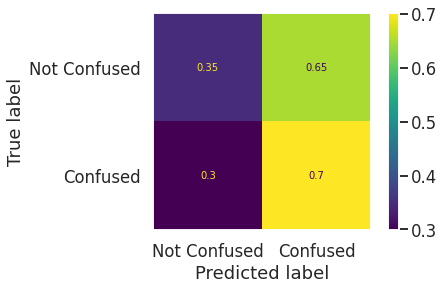

In [ ]:
# caclulate confusion matrix to visualize TP, FP, TN, FN rates 
plot_confusion_matrix(rf_model,X_test,y_test,normalize='true', display_labels=['Not Confused', 'Confused'])
plt.grid(False)

In [ ]:
# calculate additional metrics -- accuracy, sensitivity 
rf_metrics = calculate_metrics(rf_true, rf_pred,)
print("Random Forest Metrics:\n", rf_metrics)

Random Forest Metrics:
 {'Accuracy': 0.522, 'Sensitivity': 0.349, 'Specificity': 0.702, 'Precision': 0.549, 'Recall': 0.349, 'F1 Score': 0.427}


In [ ]:
# calculate regressor metrics MSE and RMSE for Random Forests model
rf_mse = mean_squared_error(rf_true, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(rf_true, rf_pred))

print("RF MSE:", rf_mse)
print("RF RMSE:", rf_rmse)

RF MSE: 0.4782608695652174
RF RMSE: 0.6915640748081247


Model Comparison on the differently split data

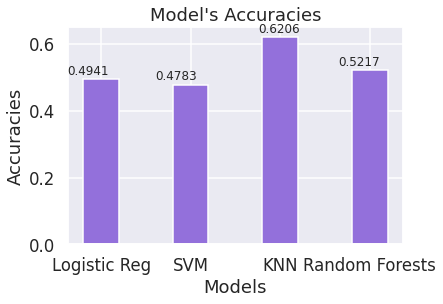

In [ ]:
# plot and visually compare the accuracies for each model
labels = ["Logistic Reg", "SVM", "KNN", "Random Forests"]
accuracies = np.round([lr_test_acc, svm_test_acc, knn_test_acc, rf_test_acc], 4)
plt.bar(labels, accuracies, color="mediumpurple", width = 0.4)
plt.xlabel("Models")
plt.ylabel("Accuracies")
plt.title("Model's Accuracies")

# add the actual values on top of the bars 
for i, v in enumerate(accuracies):
  plt.text(accuracies[i] + (i - 0.87), v + 0.015, str(v), size=12)
plt.show()

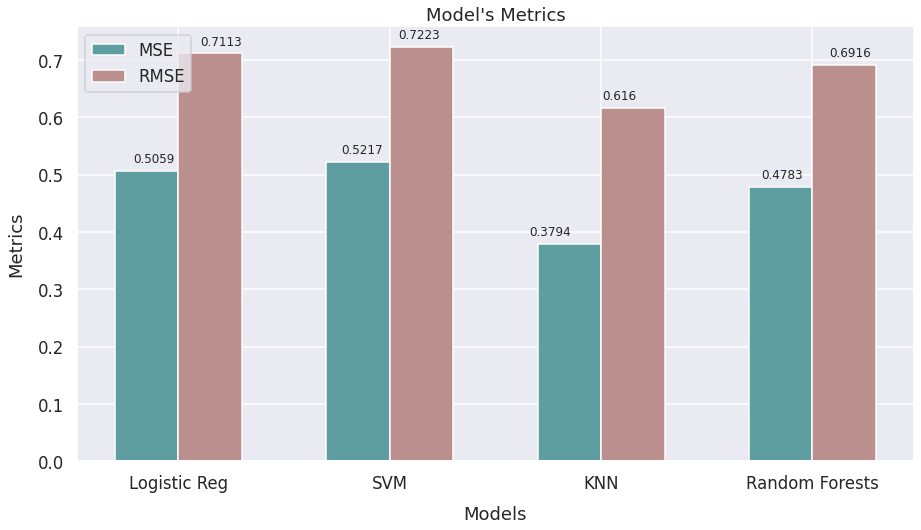

In [ ]:
# plot and visually compare the MSE and RMSE for each model
labels = ["Logistic Reg", "SVM", "KNN", "Random Forests"]
MSE = np.round([lr_mse, svm_mse, knn_mse, rf_mse], 4)
RMSE = np.round([lr_rmse, svm_rmse, knn_rmse, rf_rmse], 4)
ind = np.arange(4)
width = 0.3

plt.figure(figsize=(15, 8))
plt.bar(ind, MSE, width, label = "MSE", color="cadetblue")
plt.bar(ind + width, RMSE, width, label = "RMSE", color="rosybrown")

plt.xlabel("Models", labelpad=13)
plt.ylabel("Metrics", labelpad=13)
plt.xticks(ind + width/2, (labels))
plt.xticks(ha= "center")
plt.title("Model's Metrics")
plt.legend(loc="upper left")

# add the actual values on top of the bars 
for i, v in enumerate(MSE):
  # evenly space out SVM
  if i == 1:
    plt.text(MSE[i] + (i - 0.6), v + 0.015, str(v), size=12)
  # evenly space out the other 3 models
  else:
    plt.text(MSE[i] + (i - 0.57), v + 0.015, str(v), size=12)
for i, v in enumerate(RMSE):
  # evenly space out SVM
  if i == 1:
    plt.text(RMSE[i] + (i - 0.53), v + 0.015, str(v), size=12)
  # evenly space out the other 3 models
  else:
      plt.text(RMSE[i] + (i - 0.46), v + 0.015, str(v), size=12)
plt.show()

After training the models and calculating the error metrics, the overall best perorming model is now the KNN model followed by Random Forests then Logistic Regression and lastly SVM. This is quite different from our earlier results where SVM performed the best and then Random Forests, Logistic Regression, and lastly KNN. If given more time, we would have conducted more anlaysis and hyperparameter tuning to see why KNN which used to be our worst performing model is now performing well on this newly split data.